### Introduction to Preprocessing and Training Stage (Hard Court Version - IWP Movement Analysis)

* Hard court (2015-2019) benchmark models for different IWP (Pinnacle) Opening to Closing movement thresholds

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [5]:
df = pd.read_csv('../../data/processed_data/df_player_all_for_EDA.csv')
df.head()

,t_id,t_ident,t_nm,t_co,t_GMT_diff,t_surf,t_ind,t_alt,t_draw_sz,t_lvl,...,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
0,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.02,0.00,-0.02,0.00
1,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,0.02,0.01,0.01,0.01,0.02,0.01,0.02,0.00,0.02,0.00
2,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.01,0.01,0.00,0.01,-0.01,0.01,0.00,0.01,-0.01,0.00
3,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,0.01,-0.01,0.00,-0.01,0.01,-0.01,0.00,-0.01,0.01,0.00
4,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.03,-0.02,-0.05,-0.03,-0.03,-0.02,-0.05,-0.03,-0.04,-0.03


In [ ]:
df.info()

### Filter Data

See notebook Intro for details and justification. 

In [56]:
# Select Hard Court Surface matches only 
df_filter = df.loc[(df["t_surf"] == 2)]

In [57]:
# Select match year inclusion
df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)]

In [58]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted. 
df_low_pass = df_filter.loc[df_filter['p_matches_ss'] <= 20, 'm_num']
df_filter = df_filter[~df_filter['m_num'].isin(df_low_pass)]

In [59]:
# Create column with absolute IWP movement for each player, from Opening to Closing (Pinnacle Sports Lines)
df_filter["IWP_change"] = abs(df_filter["p_PS_C_IP"] - df_filter["p_PS_O_IP"])
df_filter["IWP_change"].max()

34.370000000000005

In [60]:
# Filter out matches with n% or greater movement from Opening to Closing
df_filter = df_filter.loc[(df_filter["IWP_change"] < 2)] #filter out (both players in a given match with) O to P change >n%

In [ ]:
df_filter.info()

Creating df variants with only the columns we will need to generate the benchmark models 

In [ ]:
df_model1 = df_filter[["p_tot_pts_won%", "p_rk_diff", "p_rk_pts_diff", "p_log_rk_diff"]]

In [61]:
df_model2 = df_filter[["p_tot_pts_won%", "p_AVG_C_IP"]]

In [ ]:
df_model3 = df_filter[["p_tot_pts_won%", "p_PS_C_IP"]]

In [ ]:
df_model4 = df_filter[["p_tot_pts_won%", "p_PS_O_IP"]]

In [ ]:
df_model1.info()

### Train Test Split

In [ ]:
len(df_model1) * .75, len(df_model1) * .25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_tot_pts_won%'), 
                                                    df_model1["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [ ]:
y_train.shape, y_test.shape

In [ ]:
y_train

In [ ]:
X_train.shape, X_test.shape

### Pre-Modeling: Mean Points Won% by a Given Player in Given Match as Predictor (aka "Dummy Model")

In [ ]:
#Target feature (p_tot_pts_won%) training set mean
train_mean = y_train.mean()
train_mean

In [ ]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

In [ ]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

In [ ]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [ ]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [ ]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

On average, we might expect to be off by around 5.05% on training set data and 4.95% on test data if you guessed a given player's percentage of points won in a given match based simply on an average of known values.

#### Mean Squared Error (MSE)

In [ ]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

#### Root Mean Squared Error (RMSE)

In [ ]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

The Dummy Model above is the ultimate straw man (we sure hope we can beat guessing with the average with all of the great data we have!). A slightly more fair comparison to our ultimate feature-rich model is a Linear Model based simply on the past match data provided by the ATP, namely player ranking and player ranking points. The ATP uses this data to decide on tournament entry status and seedings, so there is assuredly trust in these metrics by the governing body of tennis as far as evaluating players on tour. 

## Benchmark Linear Model Based on Player Ranking Data-Derived Features 

In [ ]:
X_train.info()

In [ ]:
#Filter existing train-test split down to just the ranking columns (train)
#X_train_ranking = X_train[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [ ]:
#Filter existing train-test split down to just the ranking columns (test)
#X_test_ranking = X_test[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [ ]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [ ]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

In [ ]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [ ]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [ ]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

In [ ]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

#### K Best Features Visualization

In [ ]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From Player Ranking-Derived Features Metrics

#### R-squared (COD)

In [ ]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

In [ ]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

#### Mean Absolute Error (MAE)

In [ ]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

In [ ]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

#### Mean Squared Error (MSE)

In [ ]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

In [ ]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

#### Root Mean Square Error (RMSE)

In [ ]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

In [ ]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

### Best Linear Model Feature Importance

In [ ]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'ranking_linearmodel_hard.pkl', modelpath)

### Save Prediction Metrics from Dummy and Ranking Data-Derived Linear Regression Models

In [ ]:
# # save other data for model comparisons in machine learning model stage
# comp_data_from4_ranking_hard = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_ranking_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_ranking_hard, f)

## Benchmark Linear Model Based on Aggregate Closing Line Data

### Train Test Split

In [62]:
len(df_model2) * .75, len(df_model2) * .25

(3184.5, 1061.5)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_model2.drop(columns='p_tot_pts_won%'), 
                                                    df_model2["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [64]:
y_train.shape, y_test.shape

((3184,), (1062,))

In [65]:
y_train

21035    44.87
16004    57.55
15950    56.60
20254    56.07
10164    56.93
         ...  
19707    43.20
16920    55.04
5107     46.96
20718    62.14
11516    50.48
Name: p_tot_pts_won%, Length: 3184, dtype: float64

In [66]:
X_train.shape, X_test.shape

((3184, 1), (1062, 1))

In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3184 entries, 21035 to 11516
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p_AVG_C_IP  3184 non-null   float64
dtypes: float64(1)
memory usage: 49.8 KB


In [68]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [69]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [70]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [71]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [72]:
#Conduct grid search for this IWP-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000013192EDE310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [73]:
#Best params from grid search for this IWP-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

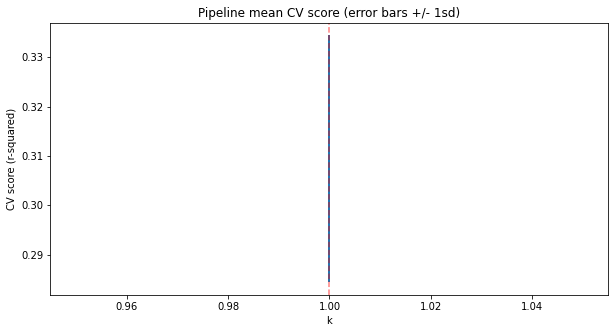

In [74]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Closing) Features Performance Metrics

#### R-squared (COD)

In [75]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.3127341 , 0.33303472, 0.29177431, 0.2714401 , 0.33791962])

In [76]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.30938057133781605, 0.025038775568144846)

#### Mean Absolute Error (MAE)

In [ ]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

In [ ]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

#### Mean Squared Error (MSE)

In [ ]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

In [ ]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

#### Root Mean Square Error (RMSE)

In [77]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [78]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.22208277613641, 0.1254566498172872)

In [79]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.3806045584133715

### Best Linear Model Feature Importance

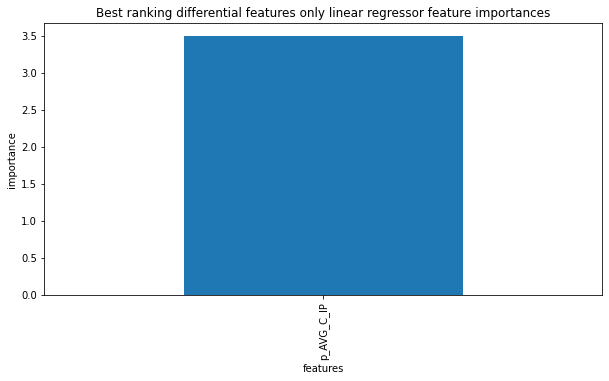

In [80]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'IWP_C_linearmodel_hard.pkl', modelpath)

### Save Prediction Metrics from IWP (Closing) Linear Regression Models

In [ ]:
# save other data for model comparisons in machine learning model stage
# comp_data_from4_IWP_C = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_IWP_C_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_IWP_C, f)

## Benchmark Linear Model Based on Closing Line Data (Pinnacle Sports Only)

In [ ]:
len(df_model3) * .75, len(df_model3) * .25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_model3.drop(columns='p_tot_pts_won%'), 
                                                    df_model3["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [ ]:
y_train.shape, y_test.shape

In [ ]:
y_train

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_train

In [ ]:
X_train.shape, X_test.shape

In [ ]:
X_train.info()

In [ ]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [ ]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

In [ ]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [ ]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [ ]:
#Conduct grid search for this IWP-restricted (Pinnacle only closing lines) model. 
lr_grid_cv.fit(X_train, y_train)

In [ ]:
#Best params from grid search for this IWP-restricted (Pinnacle only closing lines) model. 
lr_grid_cv.best_params_

In [ ]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Pinnacle Closing Lines) Features Performance Metrics

#### R-squared (COD)

In [ ]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

In [ ]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

#### Mean Absolute Error (MAE)

In [ ]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

In [ ]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

#### Mean Squared Error (MSE)

In [ ]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [ ]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

In [ ]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

#### Root Mean Square Error (RMSE)

In [ ]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

In [ ]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

### Best Linear Model Feature Importance

In [ ]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'IWP_PINNY_C_linearmodel_hard.pkl', modelpath)

In [ ]:
# save other data for model comparisons in machine learning model stage
# comp_data_from4_IWP_PINNY_C = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_IWP_PINNY_C_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_IWP_PINNY_C, f)

## Benchmark Linear Model Based on Opening Line Data (Pinnacle Sports Only)

### Train Test Split

In [ ]:
len(df_model4) * .75, len(df_model4) * .25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_model4.drop(columns='p_tot_pts_won%'), 
                                                    df_model4["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [ ]:
y_train.shape, y_test.shape

In [ ]:
y_train

In [ ]:
X_train.shape, X_test.shape

In [ ]:
X_train.info()

In [ ]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [ ]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

In [ ]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [ ]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [ ]:
#Conduct grid search for this IWP-restricted (opening lines) model. 
lr_grid_cv.fit(X_train, y_train)

In [ ]:
#Best params from grid search for this IWP-restricted model
lr_grid_cv.best_params_

In [ ]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Pinnacle Opening Lines) Features Performance Metrics

#### R-squared (COD)

In [ ]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

In [ ]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

#### Mean Absolute Error (MAE)

In [ ]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

In [ ]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

#### Mean Squared Error (MSE)

In [ ]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

In [ ]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

#### Root Mean Square Error (RMSE)

In [ ]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

In [ ]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

### Best Linear Model Feature Importance

In [ ]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'IWP_PINNY_O_linearmodel_hard.pkl', modelpath)

In [ ]:
# save other data for model comparisons in machine learning model stage
# comp_data_from4_IWP_PINNY_O = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_IWP_PINNY_O_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_IWP_PINNY_O, f)

### Conclusions

Aggregate Closing Line Only

All Matches
* Linear Model Using IWPs from Aggregate Closing Lines: 5.32% (.05%) Train; 5.19% Test

10% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: 5.30% (.08%) Train; 5.25% Test

7.5% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: 5.29% (.14%) Train; 5.22% Test

5% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: 5.28% (.06%) Train; 5.19% Test

4% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: % (%) Train; % Test

3% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: % (%) Train; % Test

2.5% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: 5.23% (.09%) Train; 5.29% Test

2% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: % (%) Train; % Test

1.25% Threshold
* Linear Model Using IWPs from Aggregate Closing Lines: 5.27% (.21%) Train; 5.28% Test
